# SLT-CE-1: Locally Linear Embedding

<h2 style="background-color:#f0b375;"> Setup </h2>

In [266]:
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as skl
import numpy as np
import scipy.sparse as sparse

from tensorflow.examples.tutorials.mnist import input_data
from sklearn.utils.validation import check_is_fitted
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D



In [267]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<p style="background-color:#adebad;">
The MNIST data set contains three sets: **mnist.train, mnist.validation, mnist.test**  
Each of them is a numpy array with samples along rows, and pixels along columns.   
The original shape of the images is 28x28 = 784.
</p>

In [268]:
mnist.train.images.shape

(55000, 784)

In [269]:
mnist.validation.images.shape

(5000, 784)

In [270]:
mnist.test.images.shape

(10000, 784)

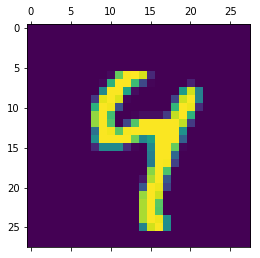

In [271]:
plt.matshow(mnist.train.images[2].reshape(28,28))
plt.show()


<h2 style="background-color:#f0b375;">
Problem 0  
<span style=font-size:50%> Complete all Problems to get the grade "1" </span>
</h2>

<p style="background-color:#adebad;">
    Shortly recapitulate the Locally Linear Embedding (LLE) algorithm, and the involved formulas.
</p>

# Summary of Locally Linear Embedding
## Purpose of the Algorithm
*Locally Linear Embedding* is an unsupervised learning algorithm for dimensionality reduction. It computes low dimensional and neighbourhood preserving embeddings of high dimensional data. It's optimizations do not involve local minima albeit it providing nonlinear embeddings.  

## Description of the Algorithm 
The algorithm takes the input X, which is a N x D matrix containing N data points of dimension D.
The algorithm returns Y, which is a N x d matrix containing N datapoints of dimension d, where usually d << D. 
It has three main steps:
1. Find the neighbors for each data point in X.
2. Find the reconstruction weights W_ij for each data point X_i, that best reconstructs X_i from its neighbors. 
    This is achieved by minimizing the eqation: 
    $$\epsilon(W) = \sum_i |\vec{X}_i - \sum_j W_{ij}\vec{X}_j|^2$$
    by constrained linear fits. 
    
    For each $X_i$, I collect its neighbors in a matrix $Z$, where each column represents one neighbor. 
    I compute $C = Z^T Z$, the local covariance matrix. 
    Then I obtain the reconstruction weights for $X_i$ by solving $Cw=1$, where $1$ denotes a column vector of ones. 
    
    Like this we obtain the matrix of reconstruction weights $W$.
3. Compute the embedding coordinates $Y$ using the weights $W$. This is achieved by minimizing:
    $$\phi(Y) = \sum_i|\vec{Y}_i - \sum_j W_{ij}Y_j|^2$$ by its bottom nonzero eigenvectors. 
    
    In particular we compute the bottom d + 1 eigenvectors of the matrix $M = (I-W)^T(I-W)$. We drop the bottom eigenvector consisting of ones. The remaining eigenvectors make up the columns of our result matrix $Y$.


<h2 style="background-color:#f0b375;"> Problem 1 </h2>

<p style="background-color:#adebad;">
    Implement the <b>fit method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
</p>

In [272]:
class LocallyLinearEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for LLE, compare to `sklearn LLE`_.
    
    Attributes:
        embedding_vectors_ (np.ndarray): Embedding of input X with shape (samples, n_components)
        nbrs_X (e.g. sklearn.neighbors.KDTree): NearestNeighbors (NN) object, stores NN for training set X.
        nbrs_y (e.g. sklearn.neighbors.KDTree): NearestNeighbors (NN) object, stores NN for embedding_vectors_.
        M_ (np.array): Symmetric matrix (dim, dim), used in quadratic form for embedding.
        X_ (np.array): Copy of training set wioth shape (samples, dim).
    
       .. _`sklearn LLE`: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html
    """
    
    def __init__(self, n_neighbors=5, n_components=2):
        self.n_neighbors = n_neighbors
        self.n_components = n_components
    
    def fit(self, X):
        """Compute LLE embedding of vectors X
        
        First, compute nbrs_X and M_.
        Finally, compute embedding_vectors_.
        
        Args:
            X (np.ndarray): Input array with shape (samples, dim)
        
        Returns:
            self
        """
        
        # Find nearest neighbours
    
        print("Computing nearest neighbors...")
        self.nbrs_X = KDTree(X, leaf_size=30, metric='euclidean')
        
        # Compute weights W
        
        W = np.zeros((X.shape[0],X.shape[0]))
        
        for i in range(X.shape[0]):
            
            dist, neighbor_indices = self.nbrs_X.query([X[i]], k=self.n_neighbors + 1)
           
            # Manually verified that nearest neighbors look more or less correct by plotting them.   
            neighbor_indices = neighbor_indices[0][1:]
              
            # Build matrix Z 
            Z = np.zeros((X.shape[1],self.n_neighbors))
            for a, neighbor_index in enumerate(neighbor_indices):
                Z[:,a] = X[neighbor_index,:] - X[i,:]
           
            # Get local covariance matrix 
            C = np.dot(np.transpose(Z),Z)
            ones = np.ones(self.n_neighbors)
            w = np.linalg.solve(C,ones)
            
            # Verified that C*w = 1
            
            # Normalize
            w = w/sum(w)
            
            # Push the found weights to W
            for a, neighbor_index in enumerate(neighbor_indices):
                W[i, neighbor_index] = w[a]
        print("Found weights...")       
        # Find M
        I = np.identity(X.shape[0])
        self.M_ = np.dot(np.transpose((I - W)),(I - W))

        print("Found M...")
        
        # Find embedding vectors
        eigenvalues, eigenvectors = np.linalg.eig(self.M_)

        self.embedding_vectors_ = np.zeros((X.shape[0], self.n_components))
            
        smallest_evs = eigenvalues.argsort()[1:self.n_components+1]
        for i,ev in enumerate(smallest_evs):
            self.embedding_vectors_[:,i] = eigenvectors[:,ev]

                    
    def transform(self, X):
        """Map new vectors X to embedding space
        
        Use the fitted model to map new vectors to the space with dimension n_components.
        
        Args:
            X (np.ndarray): Input array with shape (new_samples, dim)
            
        Returns:
            y (np.ndarray): Embedded vectors with shape (new_samples, n_components)
        """
        check_is_fitted(self, ["embedding_vectors_", "nbrs_X"])
        
        # Find nearest neighbors of new points in old points.
        # We stack the data we trained on and the new data.
        X_new = np.concatenate((self.X_,X), axis=0)
        nbrs_new_X = KDTree(X_new, leaf_size=30, metric='euclidean')
        
        W = np.zeros((X.shape[0],self.X_.shape[0]))
        
        offset = self.X_.shape[0]
        
                
        # Get reconstruction weights the same way as above. 
        
        for i in range(X.shape[0]):
            dist, neighbor_indices = nbrs_new_X.query([X[i]], 200)
           
            # Manually verified that nearest neighbors look more or less correct by plotting them.   
            neighbor_indices = neighbor_indices[0][1:]
            
            neighbor_indices = [x for x in neighbor_indices if x < offset]
            neighbor_indices = neighbor_indices[:self.n_neighbors]
            
            # Validated: Does give us similar looking images in the original data set.
            
            # TODO: adjust the references to matrices to match the new use case.
            # Build matrix Z 
            Z = np.zeros((X.shape[1],self.n_neighbors))
            for a, neighbor_index in enumerate(neighbor_indices):
                Z[:,a] = self.X_[neighbor_index,:] - X[i,:]
    
            # Get local covariance matrix 
            C = np.dot(np.transpose(Z),Z)
            ones = np.ones(self.n_neighbors)
            w = np.linalg.solve(C,ones)
            
            # Verified that C*w = 1
            
            # Normalize
            w = w/sum(w)
            
            # Push the found weights to W
            for a, neighbor_index in enumerate(neighbor_indices):
                W[i, neighbor_index] = w[a]
    
        
        # Build new points in new space using embedding vectors.
        y = np.zeros((X.shape[0],self.n_components))
        y = np.dot(W,self.embedding_vectors_)

        return y
            

    def inverse_transform(self,y):
        """Map new vectors y to input space with dimension dim.
        
        Use the fitted model to map vectors y to the original input space.
        
        Args:
            y (np.ndarray): Input array with shape (new_samples, n_components)
            
        Returns:
            X (np.ndarray): Vectors with shape (new_samples, dim)
        """
        self.nbrs_y = KDTree(self.embedding_vectors_, leaf_size=30, metric='euclidean')


        check_is_fitted(self, ["embedding_vectors_", "X_", "nbrs_y"])
        n_new_samples = y.shape[0]
        
        W = np.zeros((y.shape[0],self.X_.shape[0]))
        for i in range(n_new_samples):
            dist, neighbor_indices = self.nbrs_y.query([y[i]], k=self.n_neighbors + 1)

            Z = np.zeros((self.n_components,self.n_neighbors))
            neighbor_indices = neighbor_indices[0][1:]

            for a, neighbor_index in enumerate(neighbor_indices):
                Z[:,a] = self.embedding_vectors_[neighbor_index] - y[i,:]

            # Get local covariance matrix 
            C = np.dot(np.transpose(Z),Z)
            ones = np.ones(self.n_neighbors)
            w = np.linalg.solve(C,ones)
            
            # Verified that C*w = 1
            
            # Normalize

            w = w/sum(w)

            # Push the found weights to W
            for a, neighbor_index in enumerate(neighbor_indices):
                W[i, neighbor_index] = w[a]
            X = np.dot(W,self.X_)
            return X
            

<p style="background-color:#adebad;">
    Create an instance of your LLE class with default parameters and fit the MNIST validation set. Record the execution time (should be about 30 sec). Furthermore, create an instance of the sklearn LLE class, and fit it with the same parameters. Again record the execution time.  
    Note, the dots should be filled in by you.
</p>

In [273]:
%%time
myLLE = LocallyLinearEmbedding()
# Adjust number of cases we use for training here:
NUMBER_OF_TRAINING_CASES = 2000
training_set = mnist.validation.images[:NUMBER_OF_TRAINING_CASES]
myLLE.X_ = training_set
myLLE.fit(training_set)

Computing nearest neighbors...
Found weights...
Found M...
CPU times: user 59.5 s, sys: 933 ms, total: 1min
Wall time: 53.1 s


The points are colored according to their classification label.


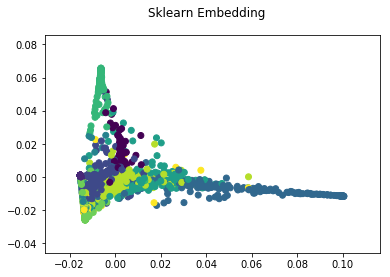

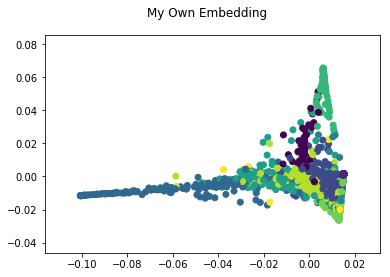

CPU times: user 16.3 s, sys: 168 ms, total: 16.5 s
Wall time: 17.1 s


In [274]:
%%time
sklLLE = manifold.LocallyLinearEmbedding(random_state=42)
sklLLE.fit(training_set)
#print(x.__dict__)
print("The points are colored according to their classification label.")
x = [x[0] for x in sklLLE.embedding_]
y = [x[1] for x in sklLLE.embedding_]

plt.suptitle('Sklearn Embedding')
plt.scatter(x,y, c= mnist.validation.labels[:len(training_set)],label=mnist.validation.labels[:len(training_set)])
plt.show()

my_x = [x[0] for x in myLLE.embedding_vectors_]
my_y = [-x[1] for x in myLLE.embedding_vectors_]

plt.suptitle('My Own Embedding')
plt.scatter(my_x,my_y,c=mnist.validation.labels[:len(training_set)])
plt.show()



<p style="background-color:#adebad;">
    Plot myLLE.embedding\_vectors\_ and sklLLE.embedding\_vectors\_ in two separate plots.
</p>

<h2 style="background-color:#f0b375;"> Problem 2 </h2>

<p style="background-color:#adebad;">
    <ul style="background-color:#adebad;">
        <li> Implement the <b>transform method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
        </li>
        
        <li>Use myLLE.transform and sklLLE.transform to map the <b>MNIST test set</b> to the LLE embedding space (Maybe you have to repeat the instantiation and fitting before you can transform). sklLLE takes about 50 sec.
        </li>
        
        <li>
            Plot both embeddings in two separate plots for comparison.
        </li>
    </ul>
</p>

In [275]:
%%time
NUMBER_OF_TEST_CASES = 1000
my_embedding = myLLE.transform(mnist.test.images[:NUMBER_OF_TEST_CASES])


CPU times: user 10.3 s, sys: 86.2 ms, total: 10.4 s
Wall time: 11.3 s


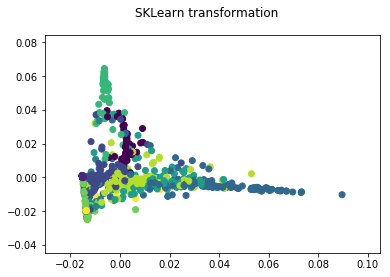

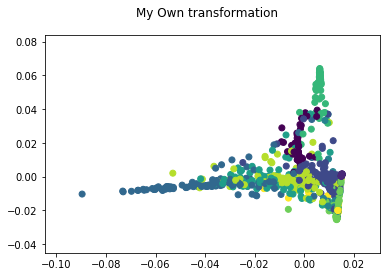

CPU times: user 7.95 s, sys: 72.7 ms, total: 8.02 s
Wall time: 8.92 s


In [276]:
%%time
skl_embedding = sklLLE.transform(mnist.test.images[:NUMBER_OF_TEST_CASES])

skl_embedding_x = [element[0] for element in skl_embedding]
skl_embedding_y = [element[1] for element in skl_embedding]
plt.scatter(skl_embedding_x,skl_embedding_y, c=mnist.test.labels[:NUMBER_OF_TEST_CASES])
plt.suptitle('SKLearn transformation')
plt.show()

new_x = [x[0] for x in my_embedding]
new_y = [-x[1] for x in my_embedding]
plt.suptitle('My Own transformation')
plt.scatter(new_x,new_y, c=mnist.test.labels[:NUMBER_OF_TEST_CASES])
plt.show()

<h2 style="background-color:#f0b375;"> Problem 3 </h2>

<ul style="background-color:#adebad;">
        <li> Implement the <b>inverse_transform method</b> for the template class LocallyLinearEmbedding, according to the contract outlined in its docstring.
        </li>
        <li>
        Use myLLE.transform and myLLE.inverse_transform to embed the first digit of the MNIST training set and then recover it. 
        </li>
       
    </ul>

In [277]:
first_image = mnist.train.images[0]

first_image = np.reshape(first_image,(1,784))

embedded_digit = myLLE.transform(first_image)

reconstructed_digit = myLLE.inverse_transform(embedded_digit)

<ul style="background-color:#adebad;">
        <li>
        Plot the original digit and the reconstructed digit for comparison.
        </li>
    </ul>

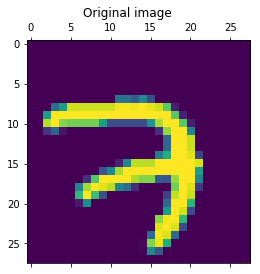

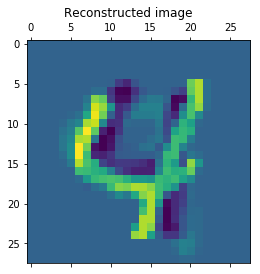

In [278]:
plt.matshow(mnist.train.images[0].reshape(28,28))
plt.suptitle('Original image')
plt.show()

plt.matshow(reconstructed_digit.reshape(28,28))
plt.suptitle('Reconstructed image')
plt.show()


<h2 style="background-color:#f0b375;"> Problem 4 </h2>

<ul style="background-color:#adebad;">
        <li>
        Perform more experiments (embeddings, reconstructions) with different parameters (e.g. n_neighbors, n_components).  
        Describe and plot the results. Make sure that it is clear what the reason of your experiments is, and what the outcome is.
        </li>
    </ul>

## Experiments
### 1. Adjusting the number of neighbors for fitting
In this "experiment", I vary the number of neighbors used when fitting the model while keeping all other variables constant. I plot the resulting embedding vectors (in the 2 dimensional target space).

For this amount of training data (N=2000), 5 neighbors do seem to give us more distinctive clusters than 1, 25 or 50 neighbors. 


Computing nearest neighbors...
Found weights...
Found M...


/Users/lorenz/miniconda3/envs/slt-ce/lib/python3.5/site-packages/ipykernel_launcher.py:79: ComplexWarning: Casting complex values to real discards the imaginary part


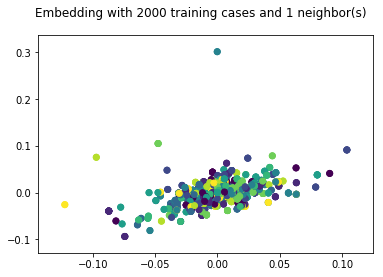

Computing nearest neighbors...
Found weights...
Found M...


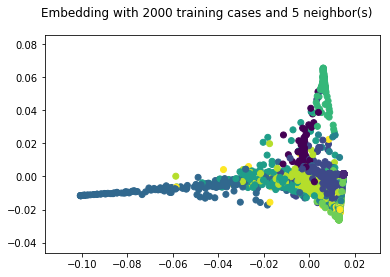

Computing nearest neighbors...
Found weights...
Found M...


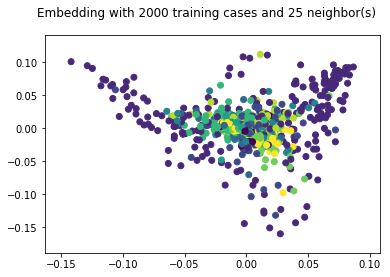

Computing nearest neighbors...
Found weights...
Found M...


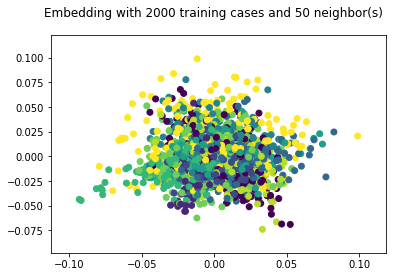

In [249]:
for k in [1,5,25,50]:
    myLLE = LocallyLinearEmbedding(n_neighbors=k)
    NUMBER_OF_TRAINING_CASES = 2000
    training_set = mnist.validation.images[:NUMBER_OF_TRAINING_CASES]
    myLLE.X_ = training_set
    myLLE.fit(training_set)
    my_x = [x[0] for x in myLLE.embedding_vectors_]
    my_y = [-x[1] for x in myLLE.embedding_vectors_]

    plt.suptitle('Embedding with {0} training cases and {1} neighbor(s)'.format(NUMBER_OF_TRAINING_CASES,k))
    plt.scatter(my_x,my_y,c=mnist.validation.labels[:len(training_set)])
    plt.show()

### 1.1 Varying the number of neighbors for the inverse transform 
I suspecting that the nearest neighbors are going to be noisier in terms of their labels in the lower dimensional space. Therefore, I want to examine what happens when we increase the number of neighbors that are being used for the inverse transform. 

Interestingly, the overall shape of the digit is cleary more similar to the original digit when using more neigbors, while we lose a lot of detail because we combine so many digits. 

Computing nearest neighbors...
Found weights...
Found M...


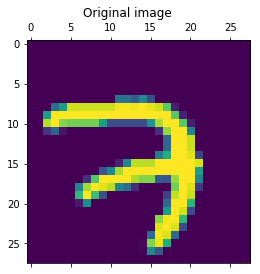

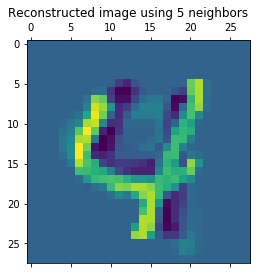

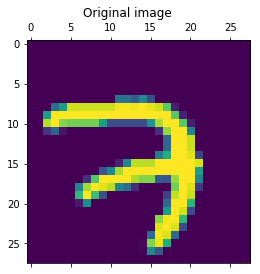

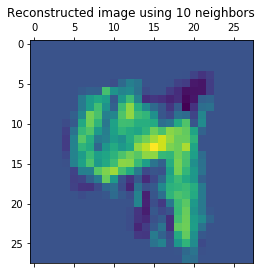

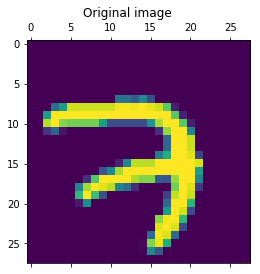

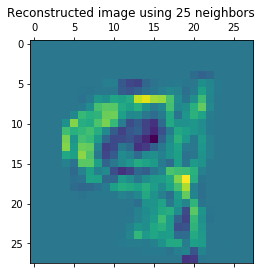

In [281]:
myLLE = LocallyLinearEmbedding(n_neighbors=5)
NUMBER_OF_TRAINING_CASES = 2000
training_set = mnist.validation.images[:NUMBER_OF_TRAINING_CASES]
myLLE.X_ = training_set
myLLE.fit(training_set)

first_image = mnist.train.images[0]
first_image = np.reshape(first_image,(1,784))
embedded_digit = myLLE.transform(first_image)

for k in [5, 10, 25]:
    myLLE.n_neighbors = k
    reconstructed_digit = myLLE.inverse_transform(embedded_digit)
    
    
    plt.matshow(mnist.train.images[0].reshape(28,28))
    plt.suptitle('Original image'.format(NUMBER_OF_TRAINING_CASES,k))
    plt.show()
    

    plt.matshow(reconstructed_digit.reshape(28,28))
    plt.suptitle('Reconstructed image using {0} neighbors'.format(k))
    plt.show()

### 2. Adjusting the amount of data used to train the model 
Here I vary the number of cases used when fitting the model while keeping the other variables constant. 

In general increasing the amount of training data seems to decrease the within-class variance of the clusters.

Computing nearest neighbors...
Found weights...
Found M...


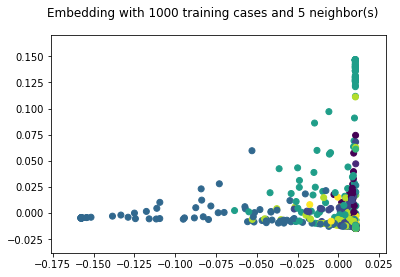

Computing nearest neighbors...


KeyboardInterrupt: 

In [280]:
for N in [1000,2000,3000,4000]:
    myLLE = LocallyLinearEmbedding(n_neighbors=5)
    NUMBER_OF_TRAINING_CASES = N
    training_set = mnist.validation.images[:NUMBER_OF_TRAINING_CASES]
    myLLE.X_ = training_set
    myLLE.fit(training_set)
    my_x = [x[0] for x in myLLE.embedding_vectors_]
    my_y = [-x[1] for x in myLLE.embedding_vectors_]

    plt.suptitle('Embedding with {0} training cases and {1} neighbor(s)'.format(NUMBER_OF_TRAINING_CASES, myLLE.n_neighbors))
    plt.scatter(my_x,my_y,c=mnist.validation.labels[:len(training_set)])
    plt.show()

### 3. Varying the dimensionality of the embedding

Here, I vary the dimensionality of the embedding space from 1 to 3, while keeping the other variables constant. 
I then plot the resulting embedding. 

Unsurprisingly, having a higher dimensional embedding space allows for a clearer distinction of the resulting clusters. 

Computing nearest neighbors...
Found weights...
Found M...


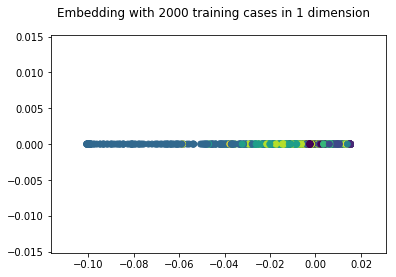

Computing nearest neighbors...
Found weights...
Found M...


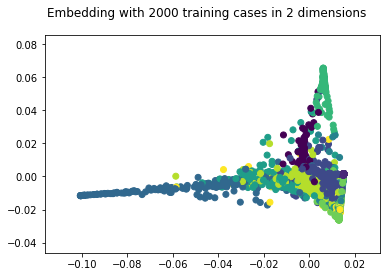

Computing nearest neighbors...
Found weights...
Found M...


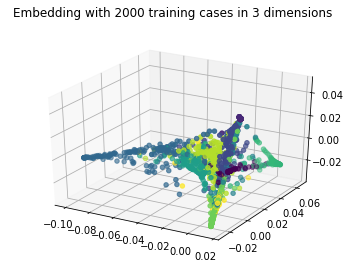

In [265]:
myLLE = LocallyLinearEmbedding(n_neighbors=5,n_components=1)
NUMBER_OF_TRAINING_CASES = 2000
training_set = mnist.validation.images[:NUMBER_OF_TRAINING_CASES]
myLLE.X_ = training_set
myLLE.fit(training_set)
my_x = [x[0] for x in myLLE.embedding_vectors_]

plt.suptitle('Embedding with {0} training cases in 1 dimension'.format(NUMBER_OF_TRAINING_CASES, myLLE.n_neighbors))
plt.scatter(my_x,np.zeros_like(my_x),c=mnist.validation.labels[:len(training_set)])
plt.show()

myLLE = LocallyLinearEmbedding(n_neighbors=5,n_components=2)

training_set = mnist.validation.images[:NUMBER_OF_TRAINING_CASES]
myLLE.X_ = training_set
myLLE.fit(training_set)
my_x = [x[0] for x in myLLE.embedding_vectors_]
my_y = [-x[1] for x in myLLE.embedding_vectors_]

plt.suptitle('Embedding with {0} training cases in 2 dimensions'.format(NUMBER_OF_TRAINING_CASES, myLLE.n_neighbors))
plt.scatter(my_x, my_y, c=mnist.validation.labels[:len(training_set)])
plt.show()

myLLE = LocallyLinearEmbedding(n_neighbors=5,n_components=3)

training_set = mnist.validation.images[:NUMBER_OF_TRAINING_CASES]
myLLE.X_ = training_set
myLLE.fit(training_set)
my_x = [x[0] for x in myLLE.embedding_vectors_]
my_y = [-x[1] for x in myLLE.embedding_vectors_]
my_z = [-x[2] for x in myLLE.embedding_vectors_]


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(my_x, my_y, my_z,c=mnist.validation.labels[:len(training_set)])
plt.suptitle('Embedding with {0} training cases in 3 dimensions'.format(NUMBER_OF_TRAINING_CASES, myLLE.n_neighbors))
plt.show()

<h2 style="background-color:#ef7575;">
Extension 1  
<span style=font-size:50%> Complete two Extensions to get the grade "2" </span>
</h2>

<ul style="background-color:#adebad;">
        <li>
        Plot the linear interpolation between two digits in the input space compared to the reconstruction along the linear interpolation of their embeddings.
        </li>
    </ul>

<ul style="background-color:#adebad;">
        <li>
        Select an image of a digit "6" and a digit "8".  
        Rotate both input images by 360° in steps of 1° and create the embedding of each rotation.  
        Plot the corresponding reconstructions, and the respective path in the 2D embedding space.  
        </li>
    </ul>

<h2 style="background-color:#ef7575;"> Extension 2 </h2>

<ul style="background-color:#adebad;">
        <li>
        Create a matrix plot of the matrix M\_.  
        Make sure to permute the rows and columns according to the digit labels, so that you can actually observe the block structure.
        </li>
        <li>
        Plot the spectrum (eigenvalues) of M\_. Can you identify a good cutoff? What could you use the value of the cutoff for?
        </li>
    </ul>

<h2 style="background-color:#ef7575;"> Extension 3 </h2>

<ul style="background-color:#adebad;">
        <li>
        Train a multilayer perceptron with two hidden layers (some width between 1000-3000) on the MNIST training set (e.g. sklearn.neural_network.MLPClassifier).
        </li>
    </ul>

<ul style="background-color:#adebad;">
        <li>
        "Embed" the MNIST validation set and the first 5000 MNIST training samples with the trained MLP.  
        To do so, use the coefs_ of the MLP to map the input digits to the first and second hidden layer.  
        In total, you should have four "embeddings": mnist_valid_1st_hidden, mnist_valid_2nd_hidden, mnist_train_1st_hidden and mnist_train_2nd_hidden.
        </li>
    </ul>

<ul style="background-color:#adebad;">
        <li>
        Use LLE to embed the "embeddings" and investigate how the embedding structure changes from raw input -> first hidden layer -> second hidden layer.
        </li>
    </ul>

<ul style="background-color:#adebad;">
        <li>
        Repeat the experiment, but this time with an autoencoder (e.g. sklearn.neural_network.MLPRegressor with fit(X,X)).  
        The hidden layers should be 200-500 units wide.  
        Not necessary for completion of Extension 3.
        </li>
    </ul>